In [ ]:
# Execute this cell to install dependencies
%pip install sf-hamilton[visualization]

# Caching + materializers tutorial [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dagworks-inc/hamilton/blob/main/examples/caching/materializer_tutorial.ipynb) [![GitHub badge](https://img.shields.io/badge/github-view_source-2b3137?logo=github)](https://github.com/dagworks-inc/hamilton/blob/main/examples/caching/materializer_tutorial.ipynb)


This notebook is a companion tutorial to the **Hamilton caching tutorial** notebook, which introduces caching more broadly.

Its **Materializers** section teaches about different usage patterns for caching + materializers and introduces the `default_loader_behavior` and `default_saver_behavior` parameters. This notebook will show how to control loader and saver behaviors granularly.

## Use cases

As a reminder, here are some potential usage patterns

**Loading data is expensive**: Your dataflow uses a `DataLoader` to get data from Snowflake. You want to load it once and cache it. When executing your dataflow, you want to use your cached copy to save query time, egress costs, etc.
- Use the `DEFAULT` caching behavior for loaders.

**Only save new data**: You run the dataflow multiple times (maybe with different parameters or on a schedule) and only want to write to destination when the data changes.
- Use the `DEFAULT` caching behavior for savers.

**Always read the latest data**: You want to use caching, but also ensure the dataflow always uses the latest data. This involves executing the `DataLoader` every time, get the data in-memory, version it, and then determine what needs to be executed (see [Changing external data](#changing-external-data)).
- Use the `RECOMPUTE` caching behavior for loaders.

> NOTE. Caching + materializers is actively being improved so default behaviors and low-level APIs might change. This is a very powerful combo. If you have ideas, questions, or use cases, please reach out on Slack!

## Set up
The next cell sets up the notebook by:
- loading the Hamilton notebook extension
- getting the caching logger
- removing any existing cache directory

In [35]:
import logging
import shutil

from hamilton import driver

CACHE_DIR = "./.materializer_and_caching_cache"

logger = logging.getLogger("hamilton.caching")
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

shutil.rmtree(CACHE_DIR, ignore_errors=True)

# load the notebook extension
%reload_ext hamilton.plugins.jupyter_magic

## TL;DR

Before diving into the details, here are the high-level ideas

Materializers are available in several flavors:
- `@dataloader` and `@datasaver`: create a custom function to serve as `DataLoader` or `DataSaver`.
- `@load_from`: use a decorator to specify that an argument should be loaded from an external source
- `@save_to`: create a node that saves the output of the decorated node
- `from_` and `to`: equivalent to `@load_from` and `@save_to` but at the `Driver`-level

When materializers and caching interact, it's important to realize the following:
- `@dataloader` and `@datasaver` are just like any other nodes and you can use `@cache` and `.with_cache()` as usual.
- `@load_from` and `@save_to` create nodes dynamically, so you there's no loader/saver function to apply `@cache` to directly. Instead, you add `@cache` to the function that has the `@load_from`/`@save_to` decorator. Also, you need to specify the name of internal nodes in `.with_cache()`, which can be trickier
- `from_` and `to` can't be decorated with `@cache` because they're defined at the `Driver`-level. Defining "static" materializers using `.with_materializers()` and `.with_cache()` is more intuitive. If you're using `Driver.materialize()` with "dynamic" materializers, you can still use `.with_cache()`. It can be more odd because `.with_cache()` will define behaviors for nodes that don't exist yet.



## `@dataloader` and `@datasaver`
### Dataflow-level

Let's rewrite the dataflow with the `@dataloader` and `@datasaver` decorators.

- **DataLoader**: the function `raw_data()` now returns a `tuple` of `(result, metadata)`. The tuple type annotation needs to specify that `raw_data` returns a `pd.DataFrame` as the first element.
- **DataSaver**: the function `saved_data()` was added. It receives `amount_per_country()` and saves it to a parquet file. It must return a dictionary, which can contain metadata.

Using the `@cache` decorator with `raw_data` or `saved_data` will apply the behavior to all associated materialization nodes.

> NOTE. the `@cache` decorator can be above or below the `@dataloader` / `@datasaver` decorator.

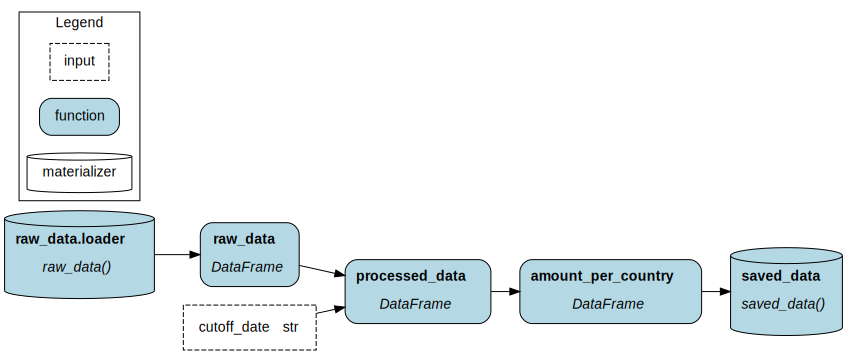

In [36]:
%%cell_to_module dataloader_dataflow_module -d
import pandas as pd
from hamilton.function_modifiers import dataloader, datasaver, cache

DATA = {
    "cities": ["New York", "Los Angeles", "Chicago", "Montréal", "Vancouver", "Houston", "Phoenix", "Mexico City", "Chihuahua City", "Rio de Janeiro"],
    "date": ["2024-09-13", "2024-09-12", "2024-09-11", "2024-09-11", "2024-09-09", "2024-09-08", "2024-09-07", "2024-09-06", "2024-09-05", "2024-09-04"],
    "amount": [478.23, 251.67, 989.34, 742.14, 584.56, 321.85, 918.67, 135.22, 789.12, 432.78],
    "country": ["USA", "USA", "USA", "Canada", "Canada", "USA", "USA", "Mexico", "Mexico", "Brazil"],
    "currency": ["USD", "USD", "USD", "CAD", "CAD", "USD", "USD", "MXN", "MXN", "BRL"],
}

@cache(behavior="recompute")
@dataloader()
def raw_data() -> tuple[pd.DataFrame, dict]:
    """Loading raw data. This simulates loading from a file, database, or external service."""
    data = pd.DataFrame(DATA)
    metadata = {"source": "notebook", "format": "json"}
    return data, metadata

def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.71  
    df.loc[df.country == "Brazil", "amound_in_usd"] *= 0.18
    df.loc[df.country == "Mexico", "amound_in_usd"] *= 0.05
    return df

def amount_per_country(processed_data: pd.DataFrame) -> pd.DataFrame:
    """Sum the amount in USD per country"""
    return processed_data.groupby("country")["amound_in_usd"].sum().to_frame()

@cache(behavior="recompute")
@datasaver()
def saved_data(amount_per_country: pd.DataFrame) -> dict:
    amount_per_country.to_parquet("./saved_data.parquet")
    metadata = {"source": "notebook", "format": "parquet"}
    return metadata

The visualization now displays the "materializer" node for the data loader. When we execute the dataflow twice and see that both `raw_data` and the associated `raw_data.loader` are recomputed.

raw_data.loader::adapter::execute_node
raw_data.loader::adapter::execute_node
raw_data::adapter::execute_node
raw_data::adapter::execute_node
processed_data::adapter::execute_node
processed_data::adapter::execute_node
amount_per_country::adapter::execute_node
amount_per_country::adapter::execute_node
saved_data::adapter::execute_node
saved_data::adapter::execute_node
raw_data.loader::adapter::execute_node
raw_data.loader::adapter::execute_node
raw_data::adapter::execute_node
raw_data::adapter::execute_node
processed_data::result_store::get_result::hit
processed_data::result_store::get_result::hit
amount_per_country::result_store::get_result::hit
amount_per_country::result_store::get_result::hit


saved_data::adapter::execute_node
saved_data::adapter::execute_node



         amound_in_usd
country               
Brazil         77.9004
Canada        941.9570
Mexico         46.2170
USA          2959.7600



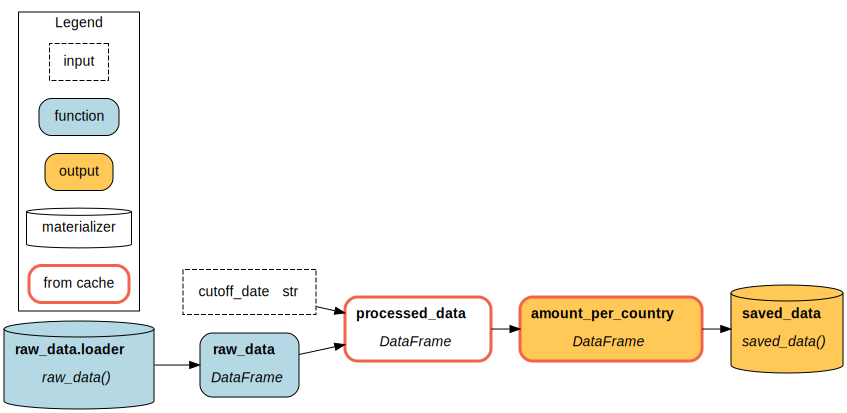

In [37]:
dataloader_dataflow_dr = (
    driver.Builder()
    .with_modules(dataloader_dataflow_module)
    .with_cache(path=CACHE_DIR)
    .build()
)

dataloader_dataflow_results = dataloader_dataflow_dr.execute(
    ["amount_per_country", "saved_data"],
    inputs={"cutoff_date": "2024-09-01"}
)
dataloader_dataflow_results = dataloader_dataflow_dr.execute(
    ["amount_per_country", "saved_data"],
    inputs={"cutoff_date": "2024-09-01"}
)
print()
print(dataloader_dataflow_results["amount_per_country"].head())
print()
dataloader_dataflow_dr.cache.view_run()

We can manually inspect the node caching behavior via the `Driver.cache`. The `RECOMPUTE` behavior applied to `raw_data` is also applied to the internal `raw_data.loader`.

In [38]:
dataloader_dataflow_dr.cache.behaviors[dataloader_dataflow_dr.cache.last_run_id]

{'amount_per_country': <CachingBehavior.DEFAULT: 1>,
 'processed_data': <CachingBehavior.DEFAULT: 1>,
 'raw_data.loader': <CachingBehavior.RECOMPUTE: 2>,
 'raw_data': <CachingBehavior.RECOMPUTE: 2>,
 'saved_data': <CachingBehavior.RECOMPUTE: 2>,
 'cutoff_date': <CachingBehavior.DEFAULT: 1>}

### Driver-level
Now, let's specify the behavior at the `Driver`-level instead. The next cell contains the same module, but without the `@cache` decorator.

In [39]:
%%cell_to_module dataloader_driver_module
import pandas as pd
from hamilton.function_modifiers import dataloader, datasaver

DATA = {
    "cities": ["New York", "Los Angeles", "Chicago", "Montréal", "Vancouver", "Houston", "Phoenix", "Mexico City", "Chihuahua City", "Rio de Janeiro"],
    "date": ["2024-09-13", "2024-09-12", "2024-09-11", "2024-09-11", "2024-09-09", "2024-09-08", "2024-09-07", "2024-09-06", "2024-09-05", "2024-09-04"],
    "amount": [478.23, 251.67, 989.34, 742.14, 584.56, 321.85, 918.67, 135.22, 789.12, 432.78],
    "country": ["USA", "USA", "USA", "Canada", "Canada", "USA", "USA", "Mexico", "Mexico", "Brazil"],
    "currency": ["USD", "USD", "USD", "CAD", "CAD", "USD", "USD", "MXN", "MXN", "BRL"],
}

@dataloader()
def raw_data() -> tuple[pd.DataFrame, dict]:
    """Loading raw data. This simulates loading from a file, database, or external service."""
    data = pd.DataFrame(DATA)
    metadata = {"source": "notebook", "format": "json"}
    return data, metadata

def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.71  
    df.loc[df.country == "Brazil", "amound_in_usd"] *= 0.18
    df.loc[df.country == "Mexico", "amound_in_usd"] *= 0.05
    return df

def amount_per_country(processed_data: pd.DataFrame) -> pd.DataFrame:
    """Sum the amount in USD per country"""
    return processed_data.groupby("country")["amound_in_usd"].sum().to_frame()

@datasaver()
def saved_data(amount_per_country: pd.DataFrame) -> dict:
    amount_per_country.to_parquet("./saved_data.parquet")
    metadata = {"source": "notebook", "format": "parquet"}
    return metadata

When building the `Driver`, we use `.with_cache(recompute=["raw_data", "saved_data"])` to specify the nodes behavior.

raw_data.loader::adapter::execute_node
raw_data.loader::adapter::execute_node
raw_data::adapter::execute_node
raw_data::adapter::execute_node
processed_data::result_store::get_result::hit
processed_data::result_store::get_result::hit
amount_per_country::result_store::get_result::hit
amount_per_country::result_store::get_result::hit
saved_data::adapter::execute_node
saved_data::adapter::execute_node



         amound_in_usd
country               
Brazil         77.9004
Canada        941.9570
Mexico         46.2170
USA          2959.7600



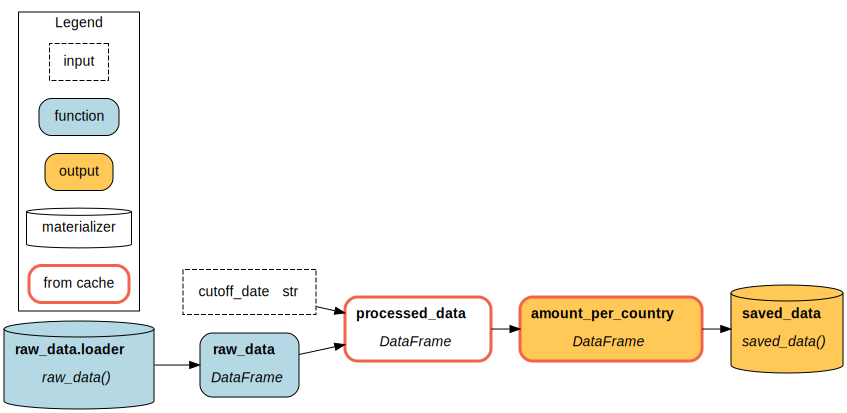

In [40]:
dataloader_driver_dr = (
    driver.Builder()
    .with_modules(dataloader_driver_module)
    .with_cache(
        path=CACHE_DIR,
        recompute=["raw_data", "saved_data"],
    )
    .build()
)

dataloader_driver_results = dataloader_driver_dr.execute(
    ["amount_per_country", "saved_data"],
    inputs={"cutoff_date": "2024-09-01"}
)
print()
print(dataloader_driver_results["amount_per_country"].head())
print()
dataloader_driver_dr.cache.view_run()

The `RECOMPUTE` behavior applied to `raw_data` is also applied to the internal `raw_data.loader`.

In [41]:
dataloader_driver_dr.cache.behaviors[dataloader_driver_dr.cache.last_run_id]

{'amount_per_country': <CachingBehavior.DEFAULT: 1>,
 'processed_data': <CachingBehavior.DEFAULT: 1>,
 'raw_data.loader': <CachingBehavior.RECOMPUTE: 2>,
 'raw_data': <CachingBehavior.RECOMPUTE: 2>,
 'saved_data': <CachingBehavior.RECOMPUTE: 2>,
 'cutoff_date': <CachingBehavior.DEFAULT: 1>}

## `@load_from` and `@save_to`
### Dataflow-level

Using `@load_from` and `@save_to` respectively remove the need to have the `raw_data()` and `saved_data()` functions. Instead, the loader/saver nodes are created a runtime, meaning we can't directly decorate them with `@cache`.

> At the time of release, the `@cache` decorator must be **under** the `@load_from` or `@save_to`. This quirk will be fixed because order shouldn't matter.  

The `@cache` decorator will be applied to `processed_data` and `amount_per_country`. By default, this will apply the behavior both to the loader node `raw_data`, but also `processed_data`. Similarly, `amount_per_country` and the generated `save.amount_per_country` will receive the behavior.

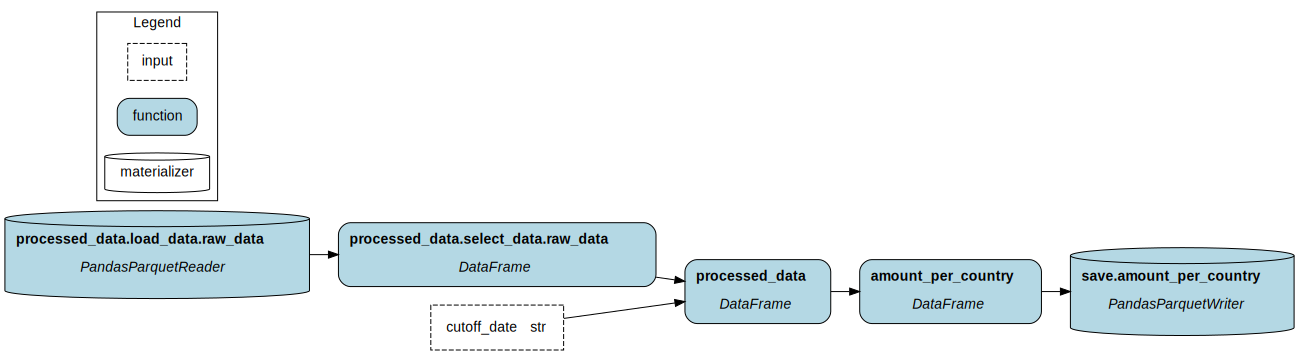

In [42]:
%%cell_to_module load_from_dataflow_module -d
import pandas as pd
from hamilton.function_modifiers import load_from, save_to, cache

DATA = {
    "cities": ["New York", "Los Angeles", "Chicago", "Montréal", "Vancouver", "Houston", "Phoenix", "Mexico City", "Chihuahua City", "Rio de Janeiro"],
    "date": ["2024-09-13", "2024-09-12", "2024-09-11", "2024-09-11", "2024-09-09", "2024-09-08", "2024-09-07", "2024-09-06", "2024-09-05", "2024-09-04"],
    "amount": [478.23, 251.67, 989.34, 742.14, 584.56, 321.85, 918.67, 135.22, 789.12, 432.78],
    "country": ["USA", "USA", "USA", "Canada", "Canada", "USA", "USA", "Mexico", "Mexico", "Brazil"],
    "currency": ["USD", "USD", "USD", "CAD", "CAD", "USD", "USD", "MXN", "MXN", "BRL"],
}

@load_from.parquet(path="raw_data.parquet", inject_="raw_data")
@cache(behavior="recompute")
def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.71  
    df.loc[df.country == "Brazil", "amound_in_usd"] *= 0.18
    df.loc[df.country == "Mexico", "amound_in_usd"] *= 0.05
    return df

@save_to.parquet(path="saved_data.parquet")
@cache(behavior="recompute")
def amount_per_country(processed_data: pd.DataFrame) -> pd.DataFrame:
    """Sum the amount in USD per country"""
    return processed_data.groupby("country")["amound_in_usd"].sum().to_frame()

The visualization displays the internal nodes generated by `@load_from` and `@save_to`.

processed_data.load_data.raw_data::adapter::execute_node
processed_data.load_data.raw_data::adapter::execute_node
processed_data.select_data.raw_data::adapter::execute_node
processed_data.select_data.raw_data::adapter::execute_node
processed_data::adapter::execute_node
processed_data::adapter::execute_node
amount_per_country::adapter::execute_node
amount_per_country::adapter::execute_node
save.amount_per_country::adapter::execute_node
save.amount_per_country::adapter::execute_node



         amound_in_usd
country               
Brazil         77.9004
Canada         941.957
Mexico          46.217
USA            2959.76



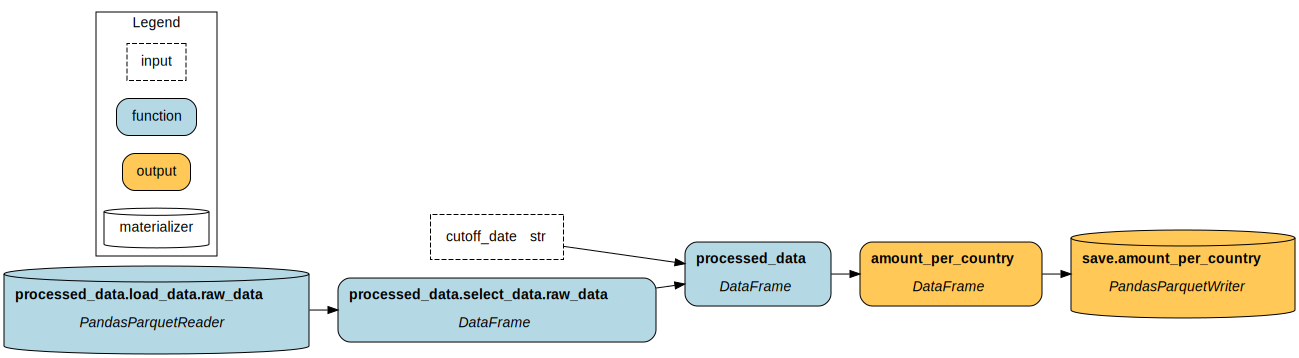

In [43]:
load_from_dataflow_dr = (
    driver.Builder()
    .with_modules(load_from_dataflow_module)
    .with_cache(path=CACHE_DIR)
    .build()
)

load_from_dataflow_results = load_from_dataflow_dr.execute(
    ["amount_per_country", "save.amount_per_country"],
    inputs={"cutoff_date": "2024-09-01"}
)
print()
print(load_from_dataflow_results["amount_per_country"].head())
print()
load_from_dataflow_dr.cache.view_run()

As expected, most nodes receive the `RECOMPUTE` behavior in this case. Note that both internal nodes `processed_data.load_data.raw_data` and `processed_data.select_data.raw_data` receive the behavior.

In [44]:
load_from_dataflow_dr.cache.behaviors[load_from_dataflow_dr.cache.last_run_id]

{'save.amount_per_country': <CachingBehavior.RECOMPUTE: 2>,
 'amount_per_country': <CachingBehavior.RECOMPUTE: 2>,
 'processed_data': <CachingBehavior.RECOMPUTE: 2>,
 'processed_data.load_data.raw_data': <CachingBehavior.RECOMPUTE: 2>,
 'processed_data.select_data.raw_data': <CachingBehavior.RECOMPUTE: 2>,
 'cutoff_date': <CachingBehavior.DEFAULT: 1>}

#### Granular control

In the previous cells, using `@cache` applied the behavior to all the nodes associated with the function decorated by `@load_from` or `@save_to`.

To achieve granular control, we can use the `target_` parameter of the `@cache` decorator where you can specify the name of the generated nodes.

For `@load_from`, we will want to target `processed_data.load_data.raw_data`. Generally, this node name has the form `f"{main_node}.load_data.{loaded_node}"`. In complex scenarios, you should also add `f"{main_node}.select_data.{loaded_node}"` to the `target_` parameter for extra safety.

For `@save_to`, we will want to target `save.amount_per_country`. The generic node name is `f"save.{main_node}"`.

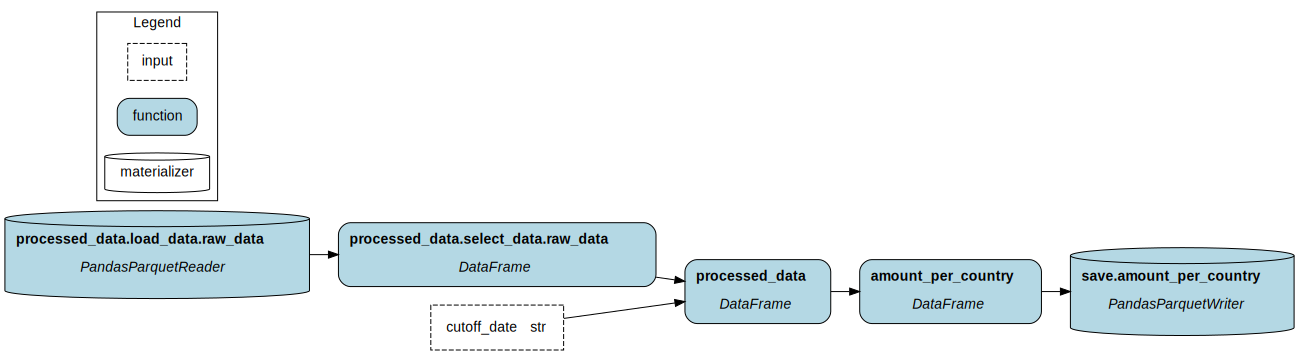

In [45]:
%%cell_to_module load_from_granular_module -d
import pandas as pd
from hamilton.function_modifiers import load_from, save_to, cache

DATA = {
    "cities": ["New York", "Los Angeles", "Chicago", "Montréal", "Vancouver", "Houston", "Phoenix", "Mexico City", "Chihuahua City", "Rio de Janeiro"],
    "date": ["2024-09-13", "2024-09-12", "2024-09-11", "2024-09-11", "2024-09-09", "2024-09-08", "2024-09-07", "2024-09-06", "2024-09-05", "2024-09-04"],
    "amount": [478.23, 251.67, 989.34, 742.14, 584.56, 321.85, 918.67, 135.22, 789.12, 432.78],
    "country": ["USA", "USA", "USA", "Canada", "Canada", "USA", "USA", "Mexico", "Mexico", "Brazil"],
    "currency": ["USD", "USD", "USD", "CAD", "CAD", "USD", "USD", "MXN", "MXN", "BRL"],
}

@load_from.parquet(path="raw_data.parquet", inject_="raw_data")
@cache(behavior="recompute", target_="processed_data.load_data.raw_data")
def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.71  
    df.loc[df.country == "Brazil", "amound_in_usd"] *= 0.18
    df.loc[df.country == "Mexico", "amound_in_usd"] *= 0.05
    return df

@save_to.parquet(path="saved_data.parquet")
@cache(behavior="recompute", target_="save.amount_per_country")
def amount_per_country(processed_data: pd.DataFrame) -> pd.DataFrame:
    """Sum the amount in USD per country"""
    return processed_data.groupby("country")["amound_in_usd"].sum().to_frame()

processed_data.load_data.raw_data::adapter::execute_node
processed_data.load_data.raw_data::adapter::execute_node
processed_data.select_data.raw_data::adapter::execute_node
processed_data.select_data.raw_data::adapter::execute_node
processed_data::adapter::execute_node
processed_data::adapter::execute_node
amount_per_country::adapter::execute_node
amount_per_country::adapter::execute_node
save.amount_per_country::adapter::execute_node
save.amount_per_country::adapter::execute_node



         amound_in_usd
country               
Brazil         77.9004
Canada         941.957
Mexico          46.217
USA            2959.76



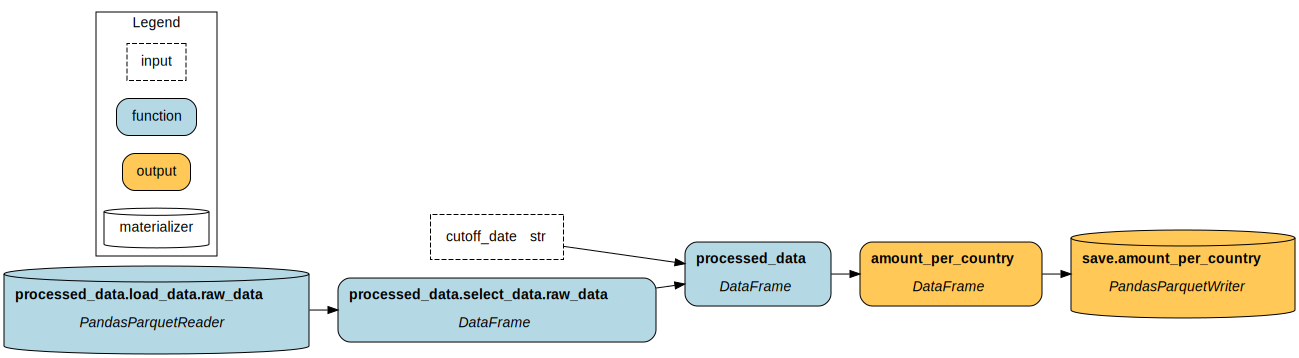

In [46]:
load_from_granular_dr = (
    driver.Builder()
    .with_modules(load_from_granular_module)
    .with_cache(path=CACHE_DIR)
    .build()
)

load_from_granular_results = load_from_granular_dr.execute(
    ["amount_per_country", "save.amount_per_country"],
    inputs={"cutoff_date": "2024-09-01"}
)
print()
print(load_from_granular_results["amount_per_country"].head())
print()
load_from_granular_dr.cache.view_run()

Here we see that the nodes decorated with `@load_from` and `@save_to` (`processed_data` and `amount_per_country`) don't receive the behavior specified in `@cache`.

In [47]:
load_from_granular_dr.cache.behaviors[load_from_granular_dr.cache.last_run_id]

{'amount_per_country': <CachingBehavior.DEFAULT: 1>,
 'save.amount_per_country': <CachingBehavior.RECOMPUTE: 2>,
 'processed_data': <CachingBehavior.DEFAULT: 1>,
 'processed_data.select_data.raw_data': <CachingBehavior.DEFAULT: 1>,
 'processed_data.load_data.raw_data': <CachingBehavior.RECOMPUTE: 2>,
 'cutoff_date': <CachingBehavior.DEFAULT: 1>}

### Driver-level

The next cell presents the same module as before, but without the `@cache` decorator.

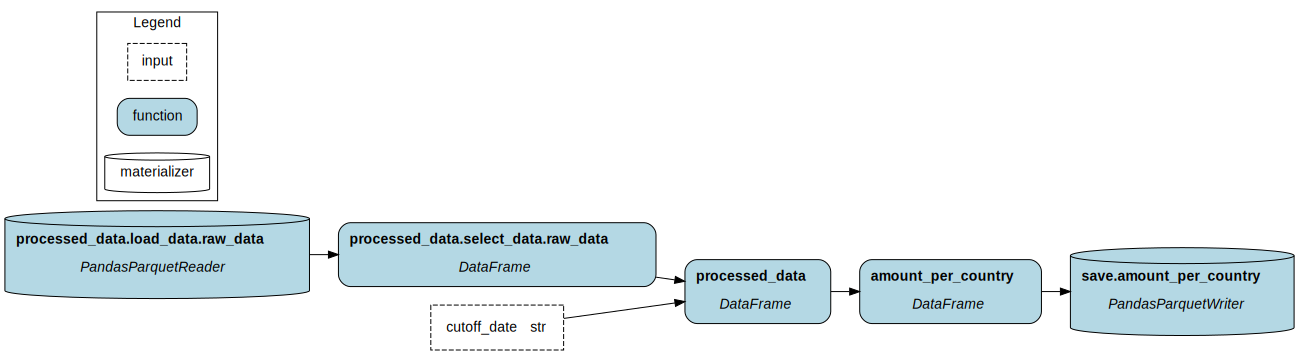

In [48]:
%%cell_to_module load_from_driver_module -d
import pandas as pd
from hamilton.function_modifiers import load_from, save_to

DATA = {
    "cities": ["New York", "Los Angeles", "Chicago", "Montréal", "Vancouver", "Houston", "Phoenix", "Mexico City", "Chihuahua City", "Rio de Janeiro"],
    "date": ["2024-09-13", "2024-09-12", "2024-09-11", "2024-09-11", "2024-09-09", "2024-09-08", "2024-09-07", "2024-09-06", "2024-09-05", "2024-09-04"],
    "amount": [478.23, 251.67, 989.34, 742.14, 584.56, 321.85, 918.67, 135.22, 789.12, 432.78],
    "country": ["USA", "USA", "USA", "Canada", "Canada", "USA", "USA", "Mexico", "Mexico", "Brazil"],
    "currency": ["USD", "USD", "USD", "CAD", "CAD", "USD", "USD", "MXN", "MXN", "BRL"],
}

@load_from.parquet(path="raw_data.parquet", inject_="raw_data")
def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.71  
    df.loc[df.country == "Brazil", "amound_in_usd"] *= 0.18
    df.loc[df.country == "Mexico", "amound_in_usd"] *= 0.05
    return df

@save_to.parquet(path="saved_data.parquet")
def amount_per_country(processed_data: pd.DataFrame) -> pd.DataFrame:
    """Sum the amount in USD per country"""
    return processed_data.groupby("country")["amound_in_usd"].sum().to_frame()

For the `.with_cache()` clause, we don't have to specify the loader's internal names; we can simply use `"raw_data"`. For the saver, we must use `"save.amount_per_country"` because this matches the name we need to pass to `Driver.execute()`.


processed_data.load_data.raw_data::adapter::execute_node
processed_data.load_data.raw_data::adapter::execute_node
processed_data.select_data.raw_data::adapter::execute_node
processed_data.select_data.raw_data::adapter::execute_node
processed_data::adapter::execute_node
processed_data::adapter::execute_node
amount_per_country::adapter::execute_node
amount_per_country::adapter::execute_node
save.amount_per_country::adapter::execute_node
save.amount_per_country::adapter::execute_node



         amound_in_usd
country               
Brazil         77.9004
Canada         941.957
Mexico          46.217
USA            2959.76



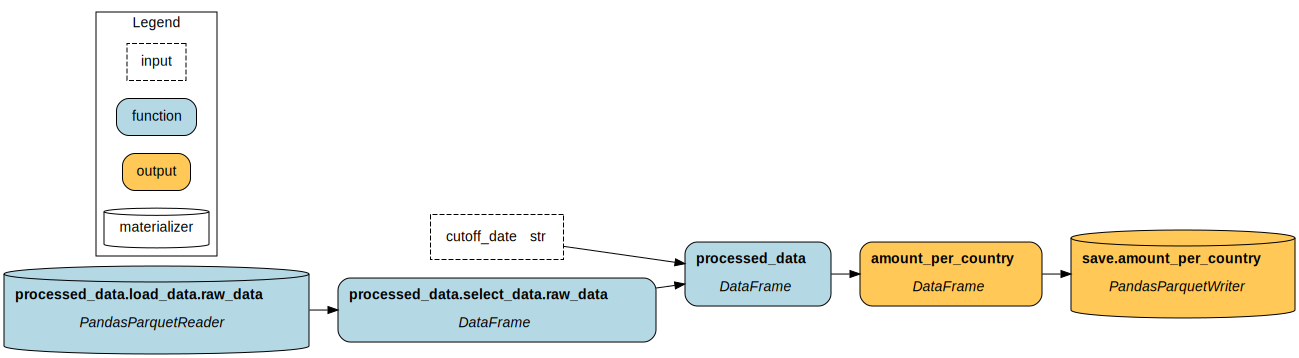

In [49]:
load_from_driver_dr = (
    driver.Builder()
    .with_modules(load_from_driver_module)
    .with_cache(
        path=CACHE_DIR,
        recompute=["raw_data", "save.amount_per_country"]
    )
    .build()
)

load_from_driver_results = load_from_driver_dr.execute(
    ["amount_per_country", "save.amount_per_country"],
    inputs={"cutoff_date": "2024-09-01"}
)
print()
print(load_from_driver_results["amount_per_country"].head())
print()
load_from_driver_dr.cache.view_run()

The internal nodes associated with `raw_data` have the right behavior. It's generally easier to use than combining `@cache` and `@load_from`/`@save_to`.

In [50]:
load_from_driver_dr.cache.behaviors[load_from_driver_dr.cache.last_run_id]

{'save.amount_per_country': <CachingBehavior.RECOMPUTE: 2>,
 'amount_per_country': <CachingBehavior.DEFAULT: 1>,
 'processed_data': <CachingBehavior.DEFAULT: 1>,
 'processed_data.load_data.raw_data': <CachingBehavior.RECOMPUTE: 2>,
 'processed_data.select_data.raw_data': <CachingBehavior.RECOMPUTE: 2>,
 'cutoff_date': <CachingBehavior.DEFAULT: 1>}

## `from_.` and `to.`
The constructs `from_` and `to` are ways of defining `DataLoader` and `DataSaver` objects at the `Driver`-level. Like the previous cells, there is no `raw_data()` or `saved_data()` nodes, but no `@load_from` & `@save_to` decorators either.

Notice in the module visualization that `raw_data` now appears as an "input" and the saver node is absent.

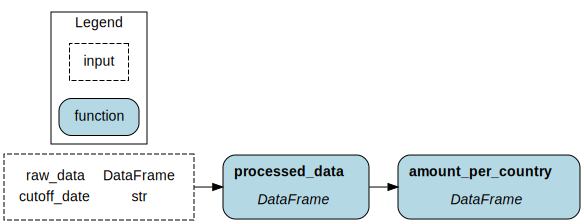

In [51]:
%%cell_to_module from_module -d
import pandas as pd

def processed_data(raw_data: pd.DataFrame, cutoff_date: str) -> pd.DataFrame:
    """Filter out rows before cutoff date and convert currency to USD."""
    df = raw_data.loc[raw_data.date > cutoff_date].copy()
    df["amound_in_usd"] = df["amount"]
    df.loc[df.country == "Canada", "amound_in_usd"] *= 0.71  
    df.loc[df.country == "Brazil", "amound_in_usd"] *= 0.18
    df.loc[df.country == "Mexico", "amound_in_usd"] *= 0.05
    return df

def amount_per_country(processed_data: pd.DataFrame) -> pd.DataFrame:
    """Sum the amount in USD per country"""
    return processed_data.groupby("country")["amound_in_usd"].sum().to_frame()

There are two ways to use `from_` and `to`:
- via "static" materializers added to the `Driver` using `Builder.with_materializers()`
- via "dynamic" materializers passed to `Driver.materialize()` (similar to `Driver.execute()`)

In both cases, it will work with the `.with_cache(recompute=...)` clause.

### `.with_materializers()`
Here, we use `.with_materializers()` to add a parquet loader for `raw_data` and a parquet saver for `amount_per_country`. Note that in `to.parquet(id=...)`, the `id` will be the node name of the data saver.

Then, we add to `.with_cache(recompute=[...])` the node names `raw_data` and `saved_data` (the saver `id`) 

We call them "static" materializers because they're attached to the `Driver`, can be visualized, and called directly via `.execute()`

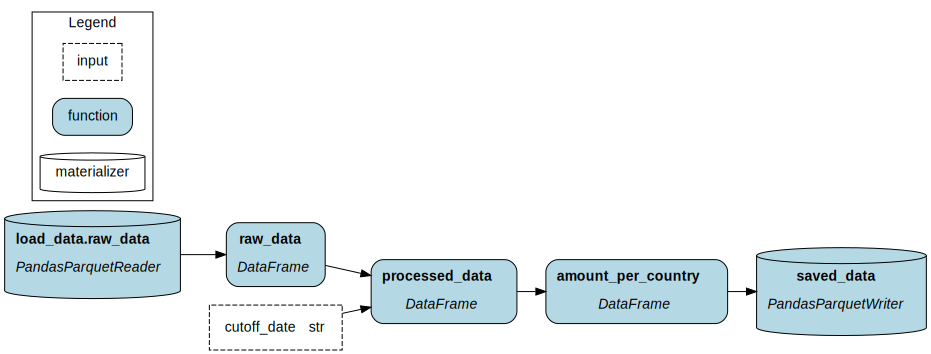

In [52]:
from hamilton.io.materialization import from_, to

static_from_dr = (
    driver.Builder()
    .with_modules(from_module)
    .with_materializers(
        from_.parquet(path="raw_data.parquet", target="raw_data"),
        to.parquet(
            id="saved_data",
            dependencies=["amount_per_country"],
            path="saved_data.parquet",
        )
    )
    .with_cache(
        path=CACHE_DIR,
        recompute=["raw_data","saved_data"],
        default_loader_behavior="disable",
    )
    .build()
)
static_from_dr

We execute the dataflow using `.execute()` and requesting the data saver's name `saved_data`.

load_data.raw_data::adapter::execute_node
load_data.raw_data::adapter::execute_node
raw_data::adapter::execute_node
raw_data::adapter::execute_node
processed_data::result_store::get_result::hit
processed_data::result_store::get_result::hit
amount_per_country::result_store::get_result::hit
amount_per_country::result_store::get_result::hit
saved_data::adapter::execute_node
saved_data::adapter::execute_node



         amound_in_usd
country               
Brazil         77.9004
Canada        941.9570
Mexico         46.2170
USA          2959.7600



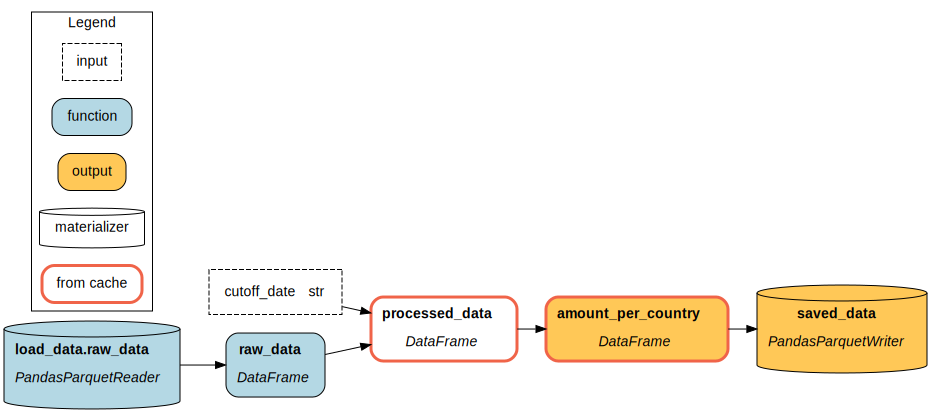

In [53]:
static_from_results = static_from_dr.execute(
    ["amount_per_country", "saved_data"],
    inputs={"cutoff_date": "2024-09-01"}
)
print()
print(static_from_results["amount_per_country"].head())
print()
static_from_dr.cache.view_run()

In [54]:
static_from_dr.cache.behaviors[static_from_dr.cache.last_run_id]

{'amount_per_country': <CachingBehavior.DEFAULT: 1>,
 'processed_data': <CachingBehavior.DEFAULT: 1>,
 'raw_data': <CachingBehavior.RECOMPUTE: 2>,
 'cutoff_date': <CachingBehavior.DEFAULT: 1>,
 'saved_data': <CachingBehavior.RECOMPUTE: 2>,
 'load_data.raw_data': <CachingBehavior.RECOMPUTE: 2>}

### `.materialize()`
Now, we build a `Driver` without the static materializers. Just like the dataflow definition, the module will show `raw_data` as an input.

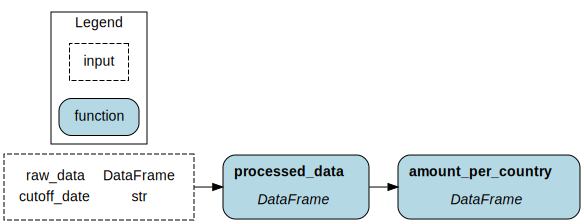

In [55]:
dynamic_from_dr = (
    driver.Builder()
    .with_modules(from_module)
    .with_cache(
        path=CACHE_DIR,
        recompute=["raw_data", "saved_data"]
    )
    .build()
)
dynamic_from_dr

The method `Driver.materialize()` has a slightly different signature than `Driver.execute()`. - The first argument collects `DataLoader` and `DataSaver` objects
- `additional_vars` is equivalent to `final_vars` in `Driver.execute()`
- it returns a tuple of `(metadata, additional_vars_results)` 

load_data.raw_data::adapter::execute_node
load_data.raw_data::adapter::execute_node
raw_data::adapter::execute_node
raw_data::adapter::execute_node
processed_data::result_store::get_result::hit
processed_data::result_store::get_result::hit
amount_per_country::result_store::get_result::hit
amount_per_country::result_store::get_result::hit
saved_data::adapter::execute_node
saved_data::adapter::execute_node



         amound_in_usd
country               
Brazil         77.9004
Canada        941.9570
Mexico         46.2170
USA          2959.7600



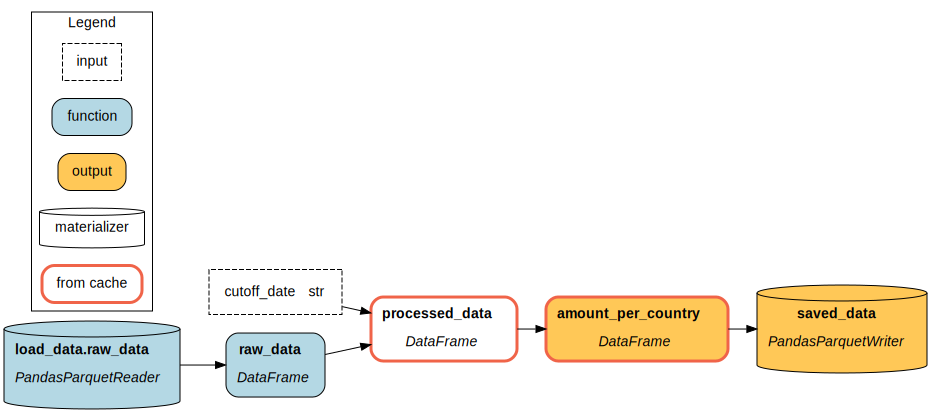

In [56]:
metadata, dynamic_from_results = dynamic_from_dr.materialize(
    from_.parquet(path="raw_data.parquet", target="raw_data"),
    to.parquet(
        id="saved_data",
        dependencies=["amount_per_country"],
        path="saved_data.parquet",
    ),
    additional_vars=["amount_per_country"],
    inputs={"cutoff_date": "2024-09-01"}
)
print()
print(dynamic_from_results["amount_per_country"].head())
print()
dynamic_from_dr.cache.view_run()

In [57]:
dynamic_from_dr.cache.behaviors[dynamic_from_dr.cache.last_run_id]

{'amount_per_country': <CachingBehavior.DEFAULT: 1>,
 'processed_data': <CachingBehavior.DEFAULT: 1>,
 'raw_data': <CachingBehavior.RECOMPUTE: 2>,
 'cutoff_date': <CachingBehavior.DEFAULT: 1>,
 'saved_data': <CachingBehavior.RECOMPUTE: 2>,
 'load_data.raw_data': <CachingBehavior.RECOMPUTE: 2>}